# Generic Conditional Laws for Random-Fields - via:

## Universal $\mathcal{P}_1(\mathbb{R})$-Deep Neural Model (Type A)

---

By: [Anastasis Kratsios](https://people.math.ethz.ch/~kratsioa/) - 2021.

---

---
# Training Algorithm:
---
## 1) Generate Data:
Generates the empirical measure $\sum_{n=1}^N \delta_{X_T(\omega_n)}$ of $X_T$ conditional on $X_0=x_0\in \mathbb{R}$ *($x_0$ and $T>0$ are user-provided)*.

## 2) Get "Sample Barycenters":
Let $\{\mu_n\}_{n=1}^N\subset\mathcal{P}_1(\mathbb{R}^d)$.  Then, the *sample barycenter* is defined by:
1. $\mathcal{M}^{(0)}\triangleq \left\{\hat{\mu}_n\right\}_{n=1}^N$,
2. For $1\leq n\leq \mbox{N sample barycenters}$: 
    - $
\mu^{\star}\in \underset{\tilde{\mu}\in \mathcal{M}^{(n)}}{\operatorname{argmin}}\, \sum_{n=1}^N \mathcal{W}_1\left(\mu^{\star},\mu_n\right),
$
    - $\mathcal{M}^{(n)}\triangleq \mathcal{M}^{(n-1)} - \{\mu^{\star}\},$
*i.e., the closest generated measure form the random sample to all other elements of the random sample.*

---
**Note:** *We simplify the computational burden of getting the correct classes by putting this right into this next loop.*

## 3) Train Deep Classifier:
$\hat{f}\in \operatorname{argmin}_{f \in \mathcal{NN}_{d:N}^{\star}} 
\sum_{x \in \mathbb{X}}
\, 
\mathbb{H}
\left(
    \operatorname{Softmax}_N\circ f(x)_n| I\left\{W_1(\hat{\mu}_n,\mu_x),\inf_{m\leq N} W_1(\hat{\mu}_m,\mu_x)\right\}
\right);
$
where $\mathbb{H}$ is the categorical cross-entropy.  

---
---
---
## Notes - Why the procedure is so computationally efficient?
---
 - The sample barycenters do not require us to solve for any new Wasserstein-1 Barycenters; which is much more computationally costly,
 - Our training procedure never back-propages through $\mathcal{W}_1$ since steps 2 and 3 are full-decoupled.  Therefore, training our deep classifier is (comparatively) cheap since it takes values in the standard $N$-simplex.

---

## Meta-Parameters

### Visualization

In [1]:
# How many random polulations to visualize:
Visualization_Size = 4

### Simulation

#### Ground Truth:
*The build-in Options:*
- rSDE 
- pfBM
- 2lnflow

In [2]:
groud_truth = "2lnflow"

#### Grid Hyperparameter(s)

In [61]:
## Monte-Carlo
N_Euler_Maruyama_Steps = 50
N_Monte_Carlo_Samples = 10**2
N_Monte_Carlo_Samples_Test = 10**1 # How many MC-samples to draw from test-set?

# End times for Time-Grid
T_end = 1
T_end_test = 1.1


## Grid
N_Grid_Finess = 10
Max_Grid = 1

# 
N_Quantizers_to_parameterize = 50

In [62]:
# Hyper-parameters of Cover
delta = 0.01
N_measures_per_center = 3

**Note**: Setting *N_Quantizers_to_parameterize* prevents any barycenters and sub-sampling.

### Random Cover

In [63]:
# TEMP:
from operator import itemgetter 
from itertools import compress
# Set Minibatch Size
Random_Cover_Mini_Batch_Size = 100
# Proportion of Clusters per Minibatch Sample
# Quantization_Proportion = 0.75

#### Mode: Code-Testin Parameter(s)

In [6]:
trial_run = True

### Meta-parameters

In [7]:
# Test-size Ratio
test_size_ratio = .25

## Simulation from Measure-Valued $2$-Parameter Log-Gaussian Flow
$$
X_{t,x} \sim \log\text{-}\mathcal{N}\left(\alpha(t,x),\beta(t,x)\right).
$$

**Note:** *$\alpha$ and $\beta$ are specified below in the SDE Example*.

## Simulation from Rough SDE
Simulate via Euler-M method from:
$$ 
X_T = x + \int_0^T \alpha(s,x)ds + \int_0^T((1-\eta)\beta(s,x)+\eta\sigma_s^H)dW_s.
$$

### Drift

In [8]:
def alpha(t,x):
    return (.1-.5*(.01**2))*t + np.cos(x)*np.exp(-t)

### Volatility

In [9]:
def beta(t,x):
    return 0.01

### Roughness Meta-parameters

In [10]:
Rougness = 0.9 # Hurst Parameter
Ratio_fBM_to_typical_vol = 0 # $\eta$ in equation above.

## Perturbed Fractional Brownian Motion
Simulate from:
$$
X_t^x(\omega) = f_1(x)f_2(t) + B_t^H(\omega).
$$

In [11]:
def field_dirction_x(x):
    return x*np.cos(x)

def finite_variation_t(t):
    return t*(np.sin(math.pi*t) + np.exp(-t))

### Get Paths

In [12]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [13]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('CV_Grid.py').read())
# Load Helper Function(s)
# %run ParaGAN_Backend.ipynb
exec(open('Helper_Functions.py').read())
# Import time separately
import time

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready


### Set Seed

In [14]:
random.seed(2021)
np.random.seed(2021)
tf.random.set_seed(2021)

## Get Internal (Hyper)-Parameter(s)
*Initialize the hyperparameters which are fully-specified by the user-provided hyperparameter(s).*

## Initialization of Auxiliary Internal-Variable(s)

In [15]:
# Initialize (Empirical) Weight(s)
measure_weights = np.ones(N_Monte_Carlo_Samples)/N_Monte_Carlo_Samples
measure_weights_test = np.ones(N_Monte_Carlo_Samples_Test)/N_Monte_Carlo_Samples_Test

# Get number of centers
N_Centers_per_box = max(1,int(round(np.sqrt(N_Quantizers_to_parameterize))))

## Get Centers Grid

In [16]:
# Generate Grid of Barycenters
x_Grid_barycenters = np.arange(start=-Max_Grid,
                               stop=Max_Grid,
                               step = (2*Max_Grid/N_Centers_per_box))
t_Grid_barycenters = np.arange(start=0,
                               stop=T_end,
                               step = (T_end/N_Centers_per_box))
for x_i in range(len(x_Grid_barycenters)):
    for t_j in range(len(t_Grid_barycenters)):
        new_grid_entry = np.array([t_Grid_barycenters[t_j],x_Grid_barycenters[x_i]]).reshape(1,-1)
        if (x_i==0 and t_j ==0):
            Grid_Barycenters = new_grid_entry
        else:
            Grid_Barycenters = np.append(Grid_Barycenters,new_grid_entry,axis=0)

# Update Number of Quantizers Generated
N_Quantizers_to_parameterize = Grid_Barycenters.shape[0]

### Generate Data
This is $\mathbb{X}$ and it represents the grid of initial states.

In [21]:
%run Simulator.ipynb

#### Start Timer (Model Type A)

In [18]:
# Start Timer
Type_A_timer_Begin = time.time()

## $2$-Parameter $\log$-Gaussian Flow
### Get Training Data

In [19]:
# Generate Training Data
for i in range(Grid_Barycenters.shape[0]):
    # Get output for center (mu-hat)
    if groud_truth == "2lnflow":
        center_current, trash = twoparameter_flow_sampler((Grid_Barycenters[i]).reshape(1,2),N_Monte_Carlo_Samples)
    
    # Get random sample in delta ball around ith center
    sub_grid_loop = np.random.uniform(0,delta,(N_measures_per_center,2)) + Grid_Barycenters[i]
    
    # Get Measures for this random sample
    if groud_truth == "2lnflow":
        measures_locations_list_current, measures_weights_list_current = twoparameter_flow_sampler(sub_grid_loop,N_Monte_Carlo_Samples)
    ##
    measures_locations_list_current = measures_locations_list_current + center_current
    measures_weights_list_current = measures_weights_list_current + trash
    # Update Classes
    Classifer_Wasserstein_Centers_loop = np.zeros([(N_measures_per_center+1),N_Quantizers_to_parameterize]) # The +1 is to account for the center which will be added to the random ball
    Classifer_Wasserstein_Centers_loop[:, i] =  1
    # Updates Classes
    if i==0:
        # INITIALIZE: Classifiers
        Classifer_Wasserstein_Centers = Classifer_Wasserstein_Centers_loop
        # INITIALIZE: Training Data
        X_train = np.append((Grid_Barycenters[i]).reshape(1,2),sub_grid_loop,axis=0)
        # INITIALIZE: Barycenters Array
        Barycenters_Array = (center_current[0]).reshape(-1,1)
        # INITIALIZE: Measures and locations
        measures_locations_list = measures_locations_list_current
        measures_weights_list = measures_weights_list_current
    else:
        # UPDATE: Classifer
        Classifer_Wasserstein_Centers = np.append(Classifer_Wasserstein_Centers,Classifer_Wasserstein_Centers_loop,axis=0)
        # UPDATE: Training Data
        X_train = np.append(X_train,np.append((Grid_Barycenters[i]).reshape(1,2),sub_grid_loop,axis=0),axis=0)
        # UPDATE: Populate Barycenters Array
        Barycenters_Array = np.append(Barycenters_Array,((center_current[0]).reshape(-1,1)),axis=-1)
        # UPDATE: Measures and locations
        measures_locations_list = measures_locations_list + measures_locations_list_current
        measures_weights_list = measures_locations_list + measures_weights_list_current

### Get Testing Data

In [20]:
# Generate Testing Dataset (Inputs)
x_tests = np.random.uniform(np.min(X_train[:,0]),np.max(X_train[:,0]),10)
t_tests = np.arange(start=0,
                    stop=T_end,
                    step = (T_end_test/N_Euler_Maruyama_Steps))

for x_i in range(len(x_tests)):
    for t_j in range(len(t_tests)):
        test_set_entry = np.array([t_tests[t_j],x_tests[x_i]]).reshape(1,-1)
        if (x_i==0 and t_j ==0):
            X_test = test_set_entry
        else:
            X_test = np.append(X_test,test_set_entry,axis=0)

# Generate Testing Dataset (Outputs)
if groud_truth == "2lnflow":
        measures_locations_test_list, measures_weights_test_list = twoparameter_flow_sampler(X_test,N_Monte_Carlo_Samples_Test)

### Rough SDE:
Simulation of the random-field:
$$
X_t^x = x + \int_0^t \alpha(s,X_t^x)ds + (1-\eta)\int_0^t \beta(s,X_t^x)dW_t + \int_0^t B_s^H dW_s;
$$
where: 
 - $(B_t^H)_t$ is a [fractional Brownian Motion](https://arxiv.org/pdf/1406.1956.pdf) with [Hurst exponent](https://en.wikipedia.org/wiki/Hurst_exponent) $H\in (0,1)$,
 - $(W_t)_t$ is a [Brownian Motion](https://en.wikipedia.org/wiki/Wiener_process),
 - $\alpha$ and $\beta$ are uniformly [Lipschitz-functions](https://en.wikipedia.org/wiki/Lipschitz_continuity) of appropriate input/output dimension.

In [58]:
%run Simulator.ipynb

In [59]:
center_current, trash, Positions, cut_frequency = Euler_Maruyama_simulator(Grid_Barycenters,N_Monte_Carlo_Samples)

100%|██████████| 49/49 [00:00<00:00, 65.99it/s]


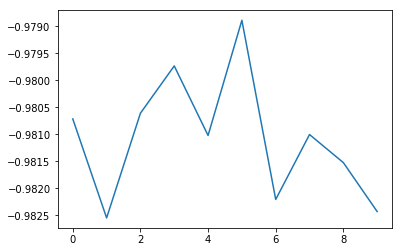

In [60]:
# cut_frequency
# plt.plot(center_current[0])
plt.plot(center_current[1])

---

In [21]:
# INDEBUG

# if groud_truth == "2lnflow":
#     print("2lnflow!")
#     measures_locations_list, measures_weights_list, X_train = measure_valued_direct_sampling(x_Grid,t_Grid,N_Monte_Carlo_Samples)
#     measures_locations_list_test, measures_weights_list_test, X_test = measure_valued_direct_sampling(x_Grid_test,t_Grid_test,N_Monte_Carlo_Samples_Test)     

# DEBUG LATER...
# if groud_truth == "rSDE":
#     print("rSDE!")
#     measures_locations_list, measures_weights_list, X_train = Euler_Maruyama_simulator(x_Grid,t_Grid,N_Monte_Carlo_Samples)
#     measures_locations_list_test, measures_weights_list_test, X_test = Euler_Maruyama_simulator(x_Grid_test,t_Grid_test,N_Monte_Carlo_Samples_Test)     
    
# if groud_truth == "pfBM":
#     print("pFBM!")
#     measures_locations_list, measures_weights_list, X_train= perturbed_fBM_simulator(x_Grid,t_Grid,N_Monte_Carlo_Samples)
#     measures_locations_list_test, measures_weights_list_test, X_test= perturbed_fBM_simulator(x_Grid_test,t_Grid_test,N_Monte_Carlo_Samples_Test)

---

### Train Deep Classifier

In this step, we train a deep (feed-forward) classifier:
$$
\hat{f}\triangleq \operatorname{Softmax}_N\circ W_J\circ \sigma \bullet \dots \sigma \bullet W_1,
$$
to identify which barycenter we are closest to.

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

#### Train Deep Classifier

In [22]:
# Re-Load Hyper-parameter Grid
exec(open('CV_Grid.py').read())
# Re-Load Classifier Function(s)
exec(open('Helper_Functions.py').read())

Deep Feature Builder - Ready
Deep Classifier - Ready


In [23]:
# Redefine (Dimension-related) Elements of Grid
param_grid_Deep_Classifier['input_dim'] = [2]
param_grid_Deep_Classifier['output_dim'] = [N_Quantizers_to_parameterize]

# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter = n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train, 
                                                                                                        y_train = Classifer_Wasserstein_Centers,
                                                                                                        X_test = X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.0s finished


Epoch 1/200
7/7 [==============================] - 0s 2ms/step - loss: 3.8840 - accuracy: 0.0306
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 3.8519 - accuracy: 0.0510
Epoch 3/200
7/7 [==============================] - 0s 2ms/step - loss: 3.8236 - accuracy: 0.0255
Epoch 4/200
7/7 [==============================] - 0s 2ms/step - loss: 3.7939 - accuracy: 0.0561
Epoch 5/200
7/7 [==============================] - 0s 2ms/step - loss: 3.7587 - accuracy: 0.0612
Epoch 6/200
7/7 [==============================] - 0s 2ms/step - loss: 3.7158 - accuracy: 0.0612
Epoch 7/200
7/7 [==============================] - 0s 4ms/step - loss: 3.6629 - accuracy: 0.1020
Epoch 8/200
7/7 [==============================] - 0s 3ms/step - loss: 3.5984 - accuracy: 0.1276
Epoch 9/200
7/7 [==============================] - 0s 4ms/step - loss: 3.5201 - accuracy: 0.1531
Epoch 10/200
7/7 [==============================] - 0s 2ms/step - loss: 3.4327 - accuracy: 0.1378
Epoch 11/200
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 0.3256 - accuracy: 1.0000
Epoch 85/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3179 - accuracy: 1.0000
Epoch 86/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3026 - accuracy: 1.0000
Epoch 87/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3092 - accuracy: 0.9847
Epoch 88/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3108 - accuracy: 0.9694
Epoch 89/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2795 - accuracy: 0.9898
Epoch 90/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2694 - accuracy: 1.0000
Epoch 91/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2730 - accuracy: 1.0000
Epoch 92/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2626 - accuracy: 1.0000
Epoch 93/200
7/7 [==============================] - 0s 2ms/step - loss: 0.2431 - accuracy: 1.0000
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 0.0401 - accuracy: 1.0000
Epoch 168/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 1.0000
Epoch 169/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0378 - accuracy: 1.0000
Epoch 170/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 1.0000
Epoch 171/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 1.0000
Epoch 172/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 1.0000
Epoch 173/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 1.0000
Epoch 174/200
7/7 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 1.0000
Epoch 175/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0343 - accuracy: 1.0000
Epoch 176/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0344 - accuracy: 1.0000
Epoch 177/200
7/7 [=====

#### Get Predicted Quantized Distributions
- Each *row* of "Predicted_Weights" is the $\beta\in \Delta_N$.
- Each *Column* of "Barycenters_Array" denotes the $x_1,\dots,x_N$ making up the points of the corresponding empirical measures.

In [24]:
# Format Weights
## Train
print("#---------------------------------------#")
print("Building Training Set (Regression): START")
print("#---------------------------------------#")
Predicted_Weights = np.array([])
for i in tqdm(range(N_Quantizers_to_parameterize)):    
    b = np.repeat(np.array(predicted_classes_train[:,i],dtype='float').reshape(-1,1),N_Monte_Carlo_Samples,axis=-1)
    b = b/N_Monte_Carlo_Samples
    if i ==0 :
        Predicted_Weights = b
    else:
        Predicted_Weights = np.append(Predicted_Weights,b,axis=1)
print("#-------------------------------------#")
print("Building Training Set (Regression): END")
print("#-------------------------------------#")

## Test
print("#-------------------------------------#")
print("Building Test Set (Predictions): START")
print("#-------------------------------------#")
Predicted_Weights_test = np.array([])
for i in tqdm(range(N_Quantizers_to_parameterize)):
    b_test = np.repeat(np.array(predicted_classes_test[:,i],dtype='float').reshape(-1,1),N_Monte_Carlo_Samples,axis=-1)
    b_test = b_test/N_Monte_Carlo_Samples
    if i ==0 :
        Predicted_Weights_test = b_test
    else:
        Predicted_Weights_test = np.append(Predicted_Weights_test,b_test,axis=1)
print("#-----------------------------------#")
print("Building Test Set (Predictions): END")
print("#-----------------------------------#")
        
# Format Points of Mass
print("#-----------------------------#")
print("Building Barycenters Set: START")
print("#-----------------------------#")
Barycenters_Array = Barycenters_Array.T.reshape(-1,)
print("#-----------------------------#")
print("Building Barycenters Set: END")
print("#-----------------------------#")

  0%|          | 0/49 [00:00<?, ?it/s]

#---------------------------------------#
Building Training Set (Regression): START
#---------------------------------------#


 14%|█▍        | 7/49 [00:00<00:00, 64.84it/s]

#-------------------------------------#
Building Training Set (Regression): END
#-------------------------------------#
#-------------------------------------#
Building Test Set (Predictions): START
#-------------------------------------#


100%|██████████| 49/49 [00:02<00:00, 22.16it/s]

#-----------------------------------#
Building Test Set (Predictions): END
#-----------------------------------#
#-----------------------------#
Building Barycenters Set: START
#-----------------------------#
#-----------------------------#
Building Barycenters Set: END
#-----------------------------#


#### Stop Timer

In [25]:
# Stop Timer
Type_A_timer_end = time.time()
# Compute Lapsed Time Needed For Training
Time_Lapse_Model_A = Type_A_timer_end - Type_A_timer_Begin

## Get Moment Predictions

#### Write Predictions

### Training-Set Result(s): 

In [26]:
print("Building Training Set Performance Metrics")

# Initialize Wasserstein-1 Error Distribution
W1_errors = np.array([])
Mean_errors = np.array([])
Var_errors = np.array([])
Skewness_errors = np.array([])
Kurtosis_errors = np.array([])
predictions_mean = np.array([])
true_mean = np.array([])
#---------------------------------------------------------------------------------------------#

# Populate Error Distribution
for x_i in tqdm(range(len(measures_locations_list)-1)):    
    # Get Laws
    W1_loop = ot.emd2_1d(Barycenters_Array,
                         np.array(measures_locations_list[x_i]).reshape(-1,),
                         Predicted_Weights[x_i,].reshape(-1,),
                         measure_weights.reshape(-1,))
    W1_errors = np.append(W1_errors,W1_loop)
    # Get Means
    Mu_hat = np.sum((Predicted_Weights[x_i])*(Barycenters_Array))
    Mu = np.mean(np.array(measures_locations_list[x_i]))
    Mean_errors =  np.append(Mean_errors,(Mu_hat-Mu))
    ## Update Erros
    predictions_mean = np.append(predictions_mean,Mu_hat)
    true_mean = np.append(true_mean,Mu)
    # Get Var (non-centered)
    Var_hat = np.sum((Barycenters_Array**2)*(Predicted_Weights[x_i]))
    Var = np.mean(np.array(measures_locations_list[x_i])**2)
    Var_errors = np.append(Var_errors,(Var_hat-Var)**2)
    # Get skewness (non-centered)
    Skewness_hat = np.sum((Barycenters_Array**3)*(Predicted_Weights[x_i]))
    Skewness = np.mean(np.array(measures_locations_list[x_i])**3)
    Skewness_errors = np.append(Skewness_errors,(abs(Skewness_hat-Skewness))**(1/3))
    # Get skewness (non-centered)
    Kurtosis_hat = np.sum((Barycenters_Array**4)*(Predicted_Weights[x_i]))
    Kurtosis = np.mean(np.array(measures_locations_list[x_i])**4)
    Kurtosis_errors = np.append(Kurtosis_errors,(abs(Kurtosis_hat-Kurtosis))**.25)
    
#---------------------------------------------------------------------------------------------#
# Compute Error Statistics/Descriptors
W1_Performance = np.array([np.min(np.abs(W1_errors)),np.mean(np.abs(W1_errors)),np.max(np.abs(W1_errors))])
Mean_prediction_Performance = np.array([np.min(np.abs(Mean_errors)),np.mean(np.abs(Mean_errors)),np.max(np.abs(Mean_errors))])
Var_prediction_Performance = np.array([np.min(np.abs(Var_errors)),np.mean(np.abs(Var_errors)),np.max(np.abs(Var_errors))])
Skewness_prediction_Performance = np.array([np.min(np.abs(Skewness_errors)),np.mean(np.abs(Skewness_errors)),np.max(np.abs(Skewness_errors))])
Kurtosis_prediction_Performance = np.array([np.min(np.abs(Kurtosis_errors)),np.mean(np.abs(Kurtosis_errors)),np.max(np.abs(Kurtosis_errors))])

Type_A_Prediction = pd.DataFrame({"W1":W1_Performance,
                                  "E[X']-E[X]":Mean_prediction_Performance,
                                  "(E[X'^2]-E[X^2])^.5":Var_prediction_Performance,
                                  "(E[X'^3]-E[X^3])^(1/3)":Skewness_prediction_Performance,
                                  "(E[X'^4]-E[X^4])^.25":Kurtosis_prediction_Performance},index=["Min","MAE","Max"])

# Write Performance
Type_A_Prediction.to_latex((results_tables_path+str("Roughness_")+str(Rougness)+str("__RatiofBM_")+str(Ratio_fBM_to_typical_vol)+
 "__TypeAPrediction_Train.tex"))


#---------------------------------------------------------------------------------------------#
# Update User
Type_A_Prediction

  5%|▌         | 10/195 [00:00<00:01, 98.14it/s]

Building Training Set Performance Metrics


100%|██████████| 195/195 [00:01<00:00, 104.00it/s]


,W1,E[X']-E[X],(E[X'^2]-E[X^2])^.5,(E[X'^3]-E[X^3])^(1/3),(E[X'^4]-E[X^4])^.25
Min,0.000014,0.000007,1.145926e-09,0.043847,0.136912
MAE,0.000309,0.004102,6.620222e-04,0.315926,0.523121
Max,0.003543,0.020852,9.719239e-03,0.736464,1.095073


---

# Visualization

#### Visualization of Training-Set Performance

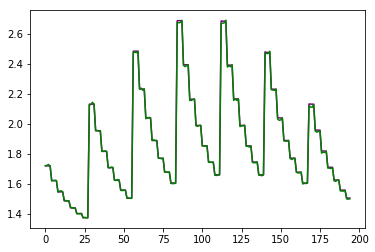

In [27]:
plt.plot(predictions_mean,label="prediction",color="purple")
plt.plot(true_mean,label="true",color="green")

### Test-Set Result(s): 

In [28]:
print("Building Test Set Performance Metrics")

# Initialize Wasserstein-1 Error Distribution
W1_errors_test = np.array([])
Mean_errors_test = np.array([])
Var_errors_test = np.array([])
Skewness_errors_test = np.array([])
Kurtosis_errors_test = np.array([])
# Initialize Prediction Metrics
predictions_mean_test = np.array([])
true_mean_test = np.array([])
#---------------------------------------------------------------------------------------------#

# Populate Error Distribution
for x_i in tqdm(range(len(measures_locations_test_list))):    
    # Get Laws
    W1_loop_test = ot.emd2_1d(Barycenters_Array,
                         np.array(measures_locations_test_list[x_i]).reshape(-1,),
                         Predicted_Weights_test[x_i,].reshape(-1,),
                         (measures_weights_test_list[x_i]).reshape(-1,))
    W1_errors_test = np.append(W1_errors_test,W1_loop_test)
    # Get Means
    Mu_hat_test = np.sum((Predicted_Weights_test[x_i])*(Barycenters_Array))
    Mu_test = np.mean(np.array(measures_locations_test_list[x_i]))
    Mean_errors_test = np.append(Mean_errors_test,(Mu_hat_test-Mu_test))
    ## Update Predictions
    predictions_mean_test = np.append(predictions_mean_test,Mu_hat_test)
    true_mean_test = np.append(true_mean_test,Mu_test)
    # Get Var (non-centered)
    Var_hat_test = np.sum((Barycenters_Array**2)*(Predicted_Weights_test[x_i]))
    Var_test = np.mean(np.array(measures_locations_test_list[x_i])**2)
    Var_errors_test = np.append(Var_errors_test,(Var_hat_test-Var_test)**2)
    # Get skewness (non-centered)
    Skewness_hat_test = np.sum((Barycenters_Array**3)*(Predicted_Weights_test[x_i]))
    Skewness_test = np.mean(np.array(measures_locations_test_list[x_i])**3)
    Skewness_errors_test = np.append(Skewness_errors_test,(abs(Skewness_hat_test-Skewness_test))**(1/3))
    # Get skewness (non-centered)
    Kurtosis_hat_test = np.sum((Barycenters_Array**4)*(Predicted_Weights_test[x_i]))
    Kurtosis_test = np.mean(np.array(measures_locations_test_list[x_i])**4)
    Kurtosis_errors_test = np.append(Kurtosis_errors_test,(abs(Kurtosis_hat_test-Kurtosis_test))**.25)
    
#---------------------------------------------------------------------------------------------#
# Compute Error Statistics/Descriptors
W1_Performance_test = np.array([np.min(np.abs(W1_errors_test)),np.mean(np.abs(W1_errors_test)),np.mean(np.abs(W1_errors_test))])
Mean_prediction_Performance_test = np.array([np.min(np.abs(Mean_errors_test)),np.mean(np.abs(Mean_errors_test)),np.mean(np.abs(Mean_errors_test))])
Var_prediction_Performance_test = np.array([np.min(np.abs(Var_errors_test)),np.mean(np.abs(Var_errors_test)),np.mean(np.abs(Var_errors_test))])
Skewness_prediction_Performance_test = np.array([np.min(np.abs(Skewness_errors_test)),np.mean(np.abs(Skewness_errors_test)),np.mean(np.abs(Skewness_errors_test))])
Kurtosis_prediction_Performance_test = np.array([np.min(np.abs(Kurtosis_errors_test)),np.mean(np.abs(Kurtosis_errors_test)),np.mean(np.abs(Kurtosis_errors_test))])

Type_A_Prediction_test = pd.DataFrame({"W1":W1_Performance_test,
                                  "E[X']-E[X]":Mean_prediction_Performance_test,
                                  "(E[X'^2]-E[X^2])^.5":Var_prediction_Performance_test,
                                  "(E[X'^3]-E[X^3])^(1/3)":Skewness_prediction_Performance_test,
                                  "(E[X'^4]-E[X^4])^.25":Kurtosis_prediction_Performance_test},index=["Min","MAE","Max"])

# Write Performance
Type_A_Prediction_test.to_latex((results_tables_path+str("Roughness_")+str(Rougness)+str("__RatiofBM_")+str(Ratio_fBM_to_typical_vol)+
 "__TypeAPrediction_Test.tex"))

  1%|          | 11/910 [00:00<00:08, 109.63it/s]

Building Test Set Performance Metrics


100%|██████████| 910/910 [00:09<00:00, 100.11it/s]


#### Visualization of Test-Set Performance

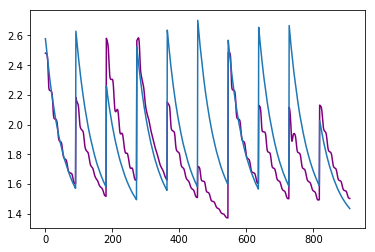

In [29]:
plt.plot(predictions_mean_test,color="purple")
plt.plot(true_mean_test)

## Update User

### Print for Terminal Legibility

In [30]:
print("#----------------------#")
print("Training-Set Performance")
print("#----------------------#")
print(Type_A_Prediction)
print(" ")
print(" ")
print(" ")

print("#------------------#")
print("Test-Set Performance")
print("#------------------#")
print(Type_A_Prediction_test)
print(" ")
print(" ")
print(" ")

#----------------------#
Training-Set Performance
#----------------------#
           W1  E[X']-E[X]  (E[X'^2]-E[X^2])^.5  (E[X'^3]-E[X^3])^(1/3)  \
Min  0.000014    0.000007         1.145926e-09                0.043847   
MAE  0.000309    0.004102         6.620222e-04                0.315926   
Max  0.003543    0.020852         9.719239e-03                0.736464   

     (E[X'^4]-E[X^4])^.25  
Min              0.136912  
MAE              0.523121  
Max              1.095073  
 
 
 
#------------------#
Test-Set Performance
#------------------#
           W1  E[X']-E[X]  (E[X'^2]-E[X^2])^.5  (E[X'^3]-E[X^3])^(1/3)  \
Min  0.000089    0.000243             0.000015                0.202964   
MAE  0.063817    0.183836             1.001850                1.138823   
Max  0.063817    0.183836             1.001850                1.138823   

     (E[X'^4]-E[X^4])^.25  
Min              0.351201  
MAE              1.371720  
Max              1.371720  
 
 
 


### Training-Set Performance

In [31]:
Type_A_Prediction

,W1,E[X']-E[X],(E[X'^2]-E[X^2])^.5,(E[X'^3]-E[X^3])^(1/3),(E[X'^4]-E[X^4])^.25
Min,0.000014,0.000007,1.145926e-09,0.043847,0.136912
MAE,0.000309,0.004102,6.620222e-04,0.315926,0.523121
Max,0.003543,0.020852,9.719239e-03,0.736464,1.095073


### Test-Set Performance

In [32]:
Type_A_Prediction_test

,W1,E[X']-E[X],(E[X'^2]-E[X^2])^.5,(E[X'^3]-E[X^3])^(1/3),(E[X'^4]-E[X^4])^.25
Min,0.000089,0.000243,0.000015,0.202964,0.351201
MAE,0.063817,0.183836,1.001850,1.138823,1.371720
Max,0.063817,0.183836,1.001850,1.138823,1.371720


---

---
# Fin
---

---